# Face tracking pipeline

The following example illustrates how to use the `facenet_pytorch` python package to perform face detection and tracking on an image dataset using MTCNN.

In [3]:
from facenet_pytorch import MTCNN
import torch
import numpy as np
import mmcv, cv2
from PIL import Image, ImageDraw
from IPython import display

#### Determine if an nvidia GPU is available

In [8]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

Running on device: cuda:0


## Get a sample video

We begin by loading a video with some faces in it. The `mmcv` PyPI package by mmlabs is used to read the video frames (it can be installed with `pip install mmcv`). Frames are then converted to PIL images.

In [5]:
video_path = '../../tests/data/Elon Musk/sample_short.mp4'

display.Video(video_path, width=640)

## Run video through MTCNN with each frame

We iterate through each frame, detect faces, and draw their bounding boxes on the video frames.

In [28]:
%%time

mtcnn = MTCNN(keep_all=True, device=device)

video = mmcv.VideoReader(video_path)
frames = [Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)) for frame in video]

bboxes_found = []
for i, frame in enumerate(frames):
    boxes, _ = mtcnn.detect(frame)
    boxes = [None] if boxes is None else boxes.tolist()

    bboxes_found += boxes

CPU times: user 1min 51s, sys: 5.97 s, total: 1min 57s
Wall time: 1min 31s


## Write rectangle around detected face regions

In [35]:
%%time

frames_tracked = []
for i, frame in enumerate(frames):    
    
    boxes = bboxes_found[i]
    
    # Draw faces
    frame_draw = frame.copy()
    draw = ImageDraw.Draw(frame_draw)
    
    if None in boxes:
        continue
    draw.rectangle(boxes, outline=(255, 0, 0), width=6)
    
    # Add to frame list
    frames_tracked.append(frame_draw.resize((640, 360), Image.BILINEAR))

CPU times: user 15.4 s, sys: 1.42 s, total: 16.8 s
Wall time: 16.8 s


#### Display detections

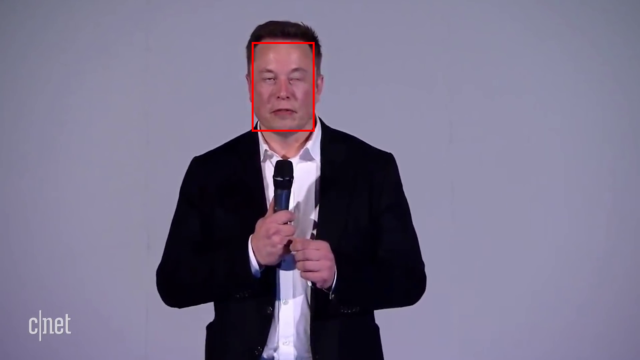

In [36]:
d = display.display(frames_tracked[0], display_id=True)
i = 1
try:
    while True:
        d.update(frames_tracked[i % len(frames_tracked)])
        i += 1
except KeyboardInterrupt:
    pass

#### Save tracked video

In [14]:
dim = frames_tracked[0].size
fourcc = cv2.VideoWriter_fourcc(*'FMP4')   

save_path = '../../tests/data/Elon Musk/従来法.mp4'
video_tracked = cv2.VideoWriter(save_path, fourcc, 25.0, dim)
for frame in frames_tracked:
    video_tracked.write(cv2.cvtColor(np.array(frame), cv2.COLOR_RGB2BGR))
video_tracked.release()